# Loading the pretrained variational autoencoder

In [1]:
import torch
import numpy as np
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils import data
from torchvision import transforms
import torch.utils.data as data_utils

In [2]:
use_pretrained = True

if use_pretrained:
  # Options to load pretrained model from google drive
  !mkdir -p /content/ml_projects/product_recommendation/prod_recommendation_enc/
  !gdown --output /content/ml_projects/product_recommendation/prod_recommendation_enc/model.pt 1-rWBZv7IFG_eGhfmBMdYXmWIMElrgfL-
  %cd /content/ml_projects/product_recommendation
else:
  # If don't use pretrained model, load workspace from gdrive
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/ml_projects/product_recommendation

Downloading...
From: https://drive.google.com/uc?id=1-rWBZv7IFG_eGhfmBMdYXmWIMElrgfL-
To: /content/ml_projects/product_recommendation/prod_recommendation_enc/model.pt
100% 37.4M/37.4M [00:00<00:00, 80.5MB/s]
/content/ml_projects/product_recommendation


In [3]:
class MnistDataset(data.Dataset):
    def __init__(self,split="train", train_ratio=0.8):
        self.split = split
        self.train_ratio = train_ratio
        self.transform   = transforms.ToTensor()
        self.mnist_train = torchvision.datasets.FashionMNIST(root="data", download=True, train=True, transform=self.transform)
        self.mnist_test  = torchvision.datasets.FashionMNIST(root="data", download=True, train=False, transform=self.transform)

        self.train_total = len(self.mnist_train)
        self.num_train   = int(self.train_total * self.train_ratio)

        if self.split == "train":
           self.data = data_utils.Subset(self.mnist_train,  torch.arange(0, self.num_train))
        if self.split == "dev":
           self.data = data_utils.Subset(self.mnist_train,  torch.arange(self.num_train, self.train_total))
        if self.split == "test":
           self.data = self.mnist_test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if isinstance(index, slice):
            return [self.__getitem__(i) for i in range(*index.indices(len(self)))]  # type: ignore
        else:
            img, label = self.data[index]
            return img, label

In [4]:
test_dataset  = MnistDataset("test")
device        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

100%|██████████| 26421880/26421880 [00:01<00:00, 16791957.81it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 264907.28it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4917514.47it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4982066.68it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

device: cpu


In [5]:
def one_hot(class_index, num_classes=10):
    result = torch.zeros(num_classes)
    result[class_index] = 1
    return result

class Encoder(nn.Module):
    def __init__(self, channel_dim, latent_dim, num_class):
        super().__init__()

        self.num_class = num_class
        self.latent_dim = latent_dim
        self.channel_dim = channel_dim
        channels_in  = [1, self.channel_dim]
        channels_out = [self.channel_dim, self.channel_dim*2]

        self.conv1 = nn.Conv2d(channels_in[0], channels_out[0], kernel_size=4, stride=2, padding=1) # in:[1,28,28], out: [c,14,14]
        self.conv2 = nn.Conv2d(channels_in[1], channels_out[1], kernel_size=4, stride=2, padding=1) # in:[c,14,14], out: [2*c,7,7]

        self.relu = nn.ReLU()

        self.fc = nn.Linear(channels_out[1]*7*7, 128)                   # in: 2*c*7*7 , out: 128
        self.fc_mu = nn.Linear(128+self.num_class, self.latent_dim)     # in: 128+num_class , out: latent_dim
        self.fc_logvar = nn.Linear(128+self.num_class, self.latent_dim) # in: 128+num_class , out: latent_dim

    def forward(self, x, y):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x_mu = self.fc_mu(torch.cat((x,y),1))
        x_logvar = self.fc_logvar(torch.cat((x,y),1))
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self, channel_dim, latent_dim, num_class):
        super().__init__()

        self.num_class = num_class
        self.latent_dim = latent_dim
        self.channel_dim = channel_dim
        channels_in  = [self.channel_dim*2, self.channel_dim]
        channels_out = [self.channel_dim, 1]

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.fc1 = nn.Linear(in_features=latent_dim, out_features=128)   # in: latent_dim , out: 128
        self.fc2 = nn.Linear(in_features=128+self.num_class, out_features=channels_in[0]*7*7)  # in: 128+num_class , out: 2*c*7*7

        self.conv2 = nn.ConvTranspose2d(channels_in[0], channels_out[0], kernel_size=4, stride=2, padding=1)  # in:[2*c,7,7], out: [c,14,14]
        self.conv1 = nn.ConvTranspose2d(channels_in[1], channels_out[1], kernel_size=4, stride=2, padding=1)  # in:[c,14,14], out: [1,28,28]

    def forward(self, x,y):
        x = self.fc2(torch.cat((self.fc1(x),y),1))
        x = x.view(x.size(0), 2*self.channel_dim, 7, 7)
        x = self.relu(self.conv2(x))
        x = self.sigmoid(self.conv1(x))
        return x

class cond_VAE(nn.Module):
    def __init__(self, channel_dim=96, latent_dim=16, num_class=10, beta=1e-2):
        super().__init__()
        self.beta, self.channel_dim, self.latent_dim, self.num_class = beta, channel_dim, latent_dim, num_class
        self.encoder = Encoder(channel_dim=96, latent_dim=16, num_class=10)
        self.decoder = Decoder(channel_dim=96, latent_dim=16, num_class=10)

    def forward(self, x, y):
        latent_mu, latent_logvar = self.encoder(x, y)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent, y)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def vae_loss(self, recon_x, x, mu, logvar):
        recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='none').sum(axis=1)
        recon_loss_batch = recon_loss.mean()
        kldivergence = (1 + logvar - mu.pow(2) - logvar.exp()).sum(axis=1)
        kldivergence_batch = -0.5 * kldivergence.mean()

        return recon_loss_batch + self.beta * kldivergence_batch, self.beta * kldivergence_batch

In [6]:
vae = cond_VAE(channel_dim=128, latent_dim=10, num_class=10, beta=1e-2)
vae = vae.to(device)
vae.train(False)

print(vae, "\n")
num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

checkpoint = torch.load('./prod_recommendation_enc/model.pt', map_location=device)
vae.load_state_dict(checkpoint['model'])

vae.eval()

image_label = []
image_embeddings = []

for image, label in test_dataset:
    with torch.no_grad():
        image_batch = image.unsqueeze(0)
        label_batch = one_hot(label).unsqueeze(0)
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch, label_batch)

        image_embeddings.append(latent_mu.squeeze(0))
        image_label.append(label)

image_embeddings = np.stack(image_embeddings, axis=0)
image_label = np.stack(image_label, axis=0)
vae.train()
print('')

cond_VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (relu): ReLU()
    (fc): Linear(in_features=9408, out_features=128, bias=True)
    (fc_mu): Linear(in_features=138, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=138, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (relu): ReLU()
    (sigmoid): Sigmoid()
    (fc1): Linear(in_features=16, out_features=128, bias=True)
    (fc2): Linear(in_features=138, out_features=9408, bias=True)
    (conv2): ConvTranspose2d(192, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv1): ConvTranspose2d(96, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
) 

Number of parameters: 3111969



# Building embeddings and the recommendation system

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea

In [8]:
unique_label = list(np.unique(image_label))
color_range  = np.linspace(0,1,len(np.unique(image_label)))
color_label  = [unique_label.index(label) for label in image_label]

In [9]:
#Note: Dimensionality reduction is used in visualization and not recommendation system
mode = "TSNE"
if mode == "PCA":
    pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=8))])
if mode == "TSNE":
    pipeline = Pipeline([('scaling', StandardScaler()), ('tsne', TSNE(n_components=2, learning_rate=100, perplexity=3))])

compressed_embeddings = pipeline.fit_transform(image_embeddings)

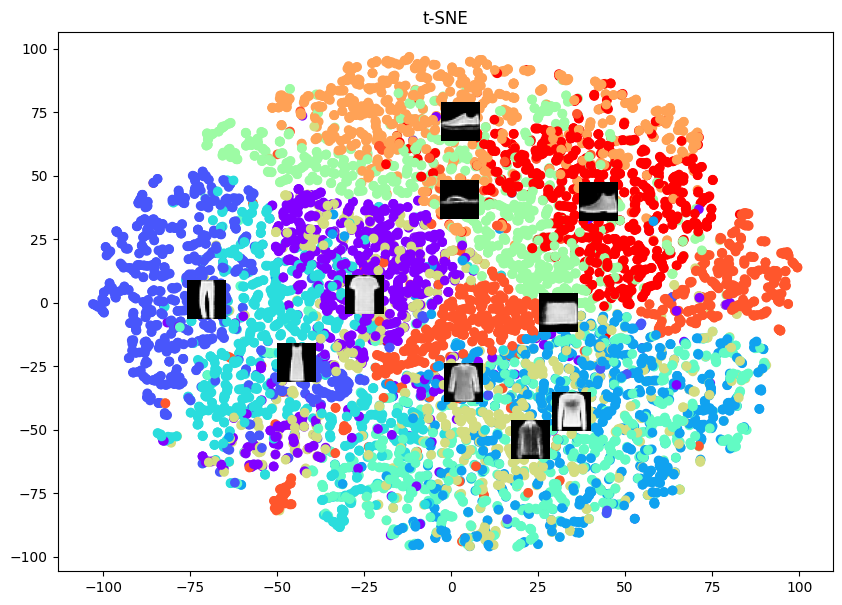

In [10]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title('t-SNE')
plt.scatter(compressed_embeddings[:, 0], compressed_embeddings[:, 1], c=color_label, cmap='rainbow')
for i in range(10):

    vae.eval()
    with torch.no_grad():
      sampling_latent = image_embeddings[image_label == i][0]
      latent_batch = torch.Tensor(sampling_latent).unsqueeze(0)
      label_batch = one_hot(i).unsqueeze(0)
      x_recon = vae.decoder(latent_batch, label_batch)[0][0].cpu().detach().numpy()
    vae.train()

    class_center = np.mean(compressed_embeddings[image_label == i], axis=0)
    im = OffsetImage(x_recon.reshape(28, 28), zoom=1, cmap='gray')
    ab = AnnotationBbox(im, (class_center[0], class_center[1]), xycoords='data', frameon=False)
    ax.add_artist(ab)

plt.show()

## Product design (using latent interpolation)

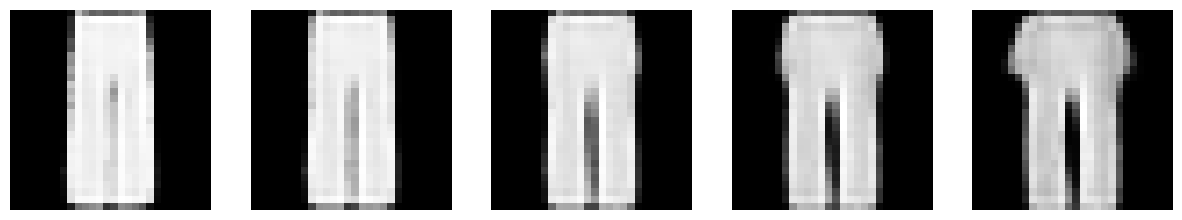

In [11]:
# @title Interpolation between two sample within a defined class

class_idx = 1 # @param @param {type:"integer"}

step_totals = np.linspace(0,1,5)

imgs = []
vae.eval()
for step in step_totals:

    with torch.no_grad():
        sampling_latent_l = image_embeddings[image_label == class_idx-1][0]
        sampling_latent_r = image_embeddings[image_label == class_idx-1][1]

        sampling_latent =  step * sampling_latent_l + (1-step) * sampling_latent_r

        latent_batch = torch.Tensor(sampling_latent).unsqueeze(0)
        label_batch = one_hot(class_idx).unsqueeze(0)
        x_recon = vae.decoder(latent_batch, label_batch)[0][0].cpu().detach().numpy()
        imgs.append(x_recon)

vae.train()

fig, ax = plt.subplots(1,5, figsize=(15, 15))
for idx, img in enumerate(imgs,0):
  ax[idx].imshow(img.reshape(28, 28), cmap='gray')
  ax[idx].set_axis_off()

plt.show()

## Recommendation system (using nearest neighbours)

Note: this section we will use 9500 sample from test set to build recommendation system and the reamaining 500 are queries

In [12]:
# @title Building Nearest neighbour structure

neigh = NearestNeighbors(n_neighbors=5, algorithm='brute')
neigh.fit(image_embeddings[:9500])

dev_label = image_label[9500:]
dev_img = image_embeddings[9500:]
distances, indices = neigh.kneighbors(dev_img)

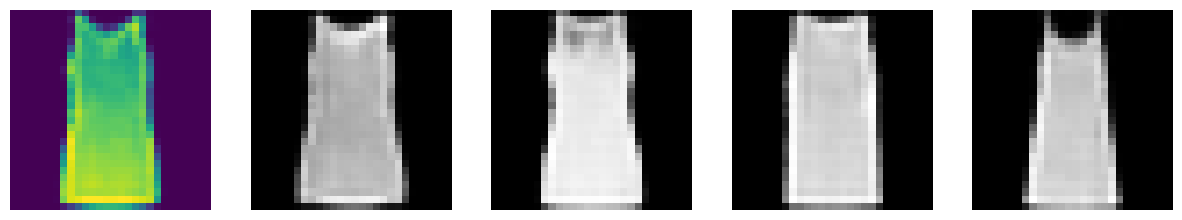

In [14]:
# @title Recommendation system using Nearest neighbour cluster

sample_idx = 2 # @param @param {type:"integer"}

fig, ax = plt.subplots(1,5, figsize=(15, 15))

with torch.no_grad():
    sampling_latent = dev_img[sample_idx-1]
    label_batch = one_hot(dev_label[sample_idx-1]).unsqueeze(0)
    latent_batch = torch.Tensor(sampling_latent).unsqueeze(0)
    x_recon = vae.decoder(latent_batch, label_batch)[0][0].cpu().detach().numpy()

ax[0].imshow(x_recon.reshape(28, 28))
ax[0].set_axis_off()

for i in range(1,5):
    with torch.no_grad():
        query_indices = indices[sample_idx-1][i]
        sampling_latent = image_embeddings[query_indices,:]
        label_batch = one_hot(image_label[query_indices]).unsqueeze(0)
        latent_batch = torch.Tensor(sampling_latent).unsqueeze(0)
        x_recon = vae.decoder(latent_batch, label_batch)[0][0].cpu().detach().numpy()
    ax[i].imshow(x_recon.reshape(28, 28), cmap='gray')
    ax[i].set_axis_off()
plt.show()